# ESM3 Template
Template for ESM3 handling. Link to [Data analysis](#Data-Analysis).

#### Dask

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38293")
client

Client Scheduler: tcp://127.0.0.1:38293 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 25.77 GB


<br>

#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
maskName = "OceanMaskVolcello2"

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
#import cdstoolbox as ct
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Data loading

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
dfFilt = df[df.variable_id.eq('thetao') & df.experiment_id.eq('historical') & df.source_id.eq('E3SM-1-0')]
dfArea = df[df.variable_id.eq('areacello') & df.source_id.eq('CESM2')]

fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)

dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[1]), consolidated=True)
dataAreaRaw = dsArea.areacello

for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets

dfESMLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
dfESMLat = dfESMLat.reset_coords(drop=True) #Removes lev if single value

globalStartDate = dfESMLat["time"][0].values
globalDateInc = dfESMLat["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dfESMLat["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("ESM data sucessfully loaded.")

ESM data sucessfully loaded.


<br>

#### Calculation Functions
<b>Functions:</b><br>
<ul>
</ul>

In [5]:
print("Calculation functions defined")

Calculation functions defined


<br>

#### Plotting Functions
<b>Functions:</b><br>
<ul>
<li>mapPlot - plots the Southern Ocean orthographic project of the input data set, with input title and figure number.
</ul>

In [6]:
def mapPlot(dataSet, title, plotNo):
    '''Displays given data set on a map'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    p.axes.coastlines()
    plt.title(str(title))

print("Plotting functions defined")

Plotting functions defined


<br>

#### Loading and checking the mask

Mask Loaded


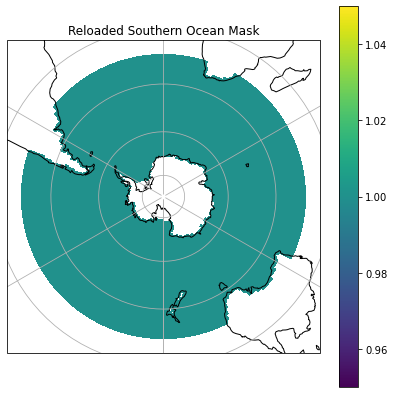

In [7]:
maskFile = xr.open_dataset(maskName)
oceanMaskReload = maskFile.to_array()
print("Mask Loaded")
mapPlot(oceanMaskReload, "Reloaded Southern Ocean Mask", 1)

<br>

#### Data Analysis